In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

from scipy.ndimage import median_filter as medfilt

n_cadences = 3#int(24 * 60 * 0.5) #  a day

def median_filter(x, n_cadences=n_cadences):
    return medfilt(x, (n_cadences, ))

from libra import k62_all_transits

In [3]:
from interpacf import interpolated_acf

In [38]:
import kplr
client = kplr.API()

names = 'Kepler-62'
koi_number = 701

# Find the target KOI.
koi = client.koi(koi_number + 0.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

lags = []
acfs = []

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for i, lc in enumerate(lcs):
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
#         time.append(hdu_data["time"] + 2454833)
#         flux.append(hdu_data["sap_flux"])
#         ferr.append(hdu_data["sap_flux_err"])
#         quality.append(hdu_data["sap_quality"])

        time_q = hdu_data["time"] + 2454833
        flux_q = hdu_data["sap_flux"]
        err_q = hdu_data["sap_flux_err"]

        err_q /= np.nanmedian(flux_q)
        flux_q /= np.nanmedian(flux_q)
        not_nans = ~np.isnan(flux_q)
        p = np.polyfit(time_q[not_nans], flux_q[not_nans], 2)
        flux_q += 1 - np.polyval(p, time_q)
        
        time.append(time_q)
        flux.append(flux_q)
        ferr.append(err_q)
        
#         flux_q = flux_q / k62_all_transits(time_q)[:, 0]

#         mask_flares = ((flux_q < 0.999) | (flux_q > 1.002)) | np.isnan(time_q) | np.isnan(flux_q)

#         flux_q = median_filter(flux_q[~mask_flares])
#         time_q = time_q[~mask_flares] 
#         # Find biggest chunk
        
#         inds = np.argsort(np.diff(time_q))[-1]
#         print(inds)
#         time_q = time_q[inds:]
#         flux_q = flux_q[inds:]
        
#         fig, ax = plt.subplots(1, 2, figsize=(12, 4))
#         ax[0].plot(time_q, flux_q)
#         ax[0].set(xlabel='Time [d]', ylabel='Flux', title='Q{0}'.format(i))
#         sort = np.argsort(time_q)
#         lag, acf = interpolated_acf(time_q[sort], flux_q[sort] - np.median(flux_q))
#         lags.append(lag)
#         acfs.append(acf)
#         ax[1].plot(lag, acf)
#         ax[1].set(xlabel='Lag [d]', ylabel='ACF')
#         fig.tight_layout()
#         plt.show()
flux = median_filter(np.concatenate(flux))
not_nans = ~np.isnan(flux) & ~np.isnan(np.concatenate(time))
time = np.concatenate(time)[not_nans]
err = np.concatenate(ferr)[not_nans]/np.nanmax(flux)
flux = flux[not_nans]/np.percentile(flux[~np.isnan(flux)], 99)

sort = np.argsort(time)
time = time[sort]
flux = flux[sort] / k62_all_transits(time)[:, 0]
err = err[sort]

mask_flares = (flux < 0.99) | (flux > 1.002)

time = time[~mask_flares]
flux = flux[~mask_flares]
err = err[~mask_flares]

#np.savetxt('k62_medfilt.txt', np.vstack([time, flux, err]).T)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


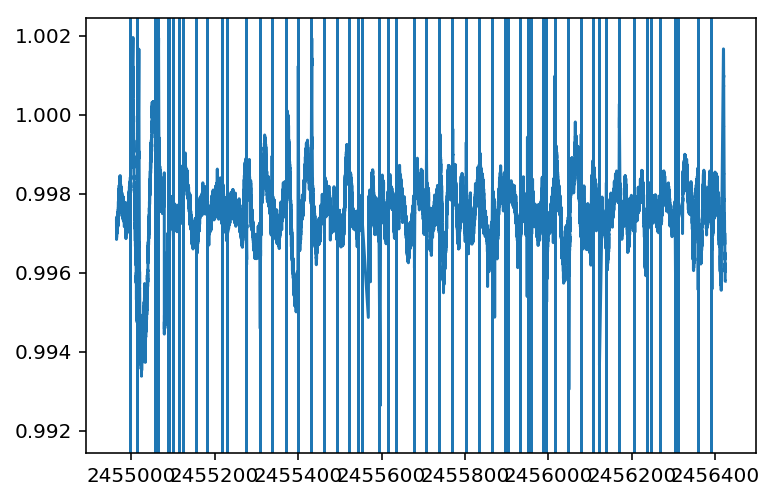

In [45]:
plt.plot(time, flux)

gaps = np.argwhere(np.diff(time) > 5 * np.median(np.diff(time)))
chunks_time = []
chunks_flux = []

for i in range(len(gaps)-1):
    plt.axvline(time[gaps[i]])

    chunks_time.append(time[gaps[i]+1:gaps[i+1]])
    chunks_flux.append(flux[gaps[i]+1:gaps[i+1]])

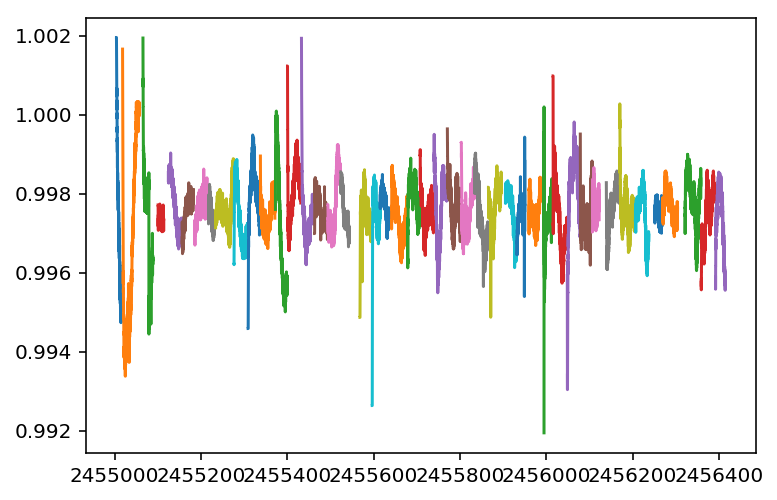

In [64]:
lags = []
acfs = []

for c_t, c_f in zip(chunks_time, chunks_flux):
    
    if c_t.ptp() > 10:
        plt.plot(c_t, c_f)

        lag, acf = interpolated_acf(c_t, c_f - np.median(c_f))
        lags.append(lag)
        acfs.append(acf)

Text(0,0.5,'ACF')

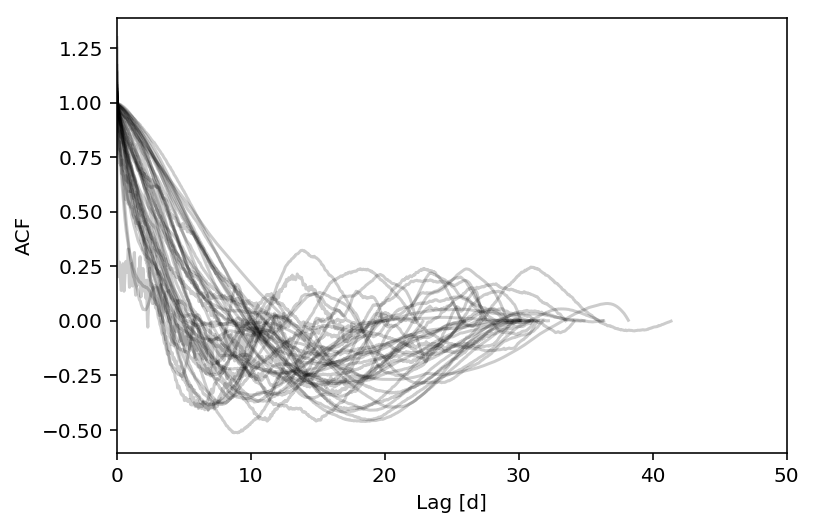

In [67]:
all_lags = np.array([])
all_acfs = np.array([])

for i, lag, acf in zip(range(len(lags)), lags, acfs):
    plt.plot(lag, acf/np.percentile(acf, 99.9), color='k', alpha=0.2)
    all_acfs = np.hstack([all_acfs, acf/np.percentile(acf, 99.9)])
    all_lags = np.hstack([all_lags, lag])

# x = np.linspace(0, 50)
# plt.plot(x, np.exp(-0.25 * x), lw=3, color='r')
plt.xlim([0, 50])
plt.xlabel('Lag [d]')
plt.ylabel('ACF')

Optimization terminated successfully.
         Current function value: 508.877008
         Iterations: 2
         Function evaluations: 42
Exponential term:  0.29515529539822544


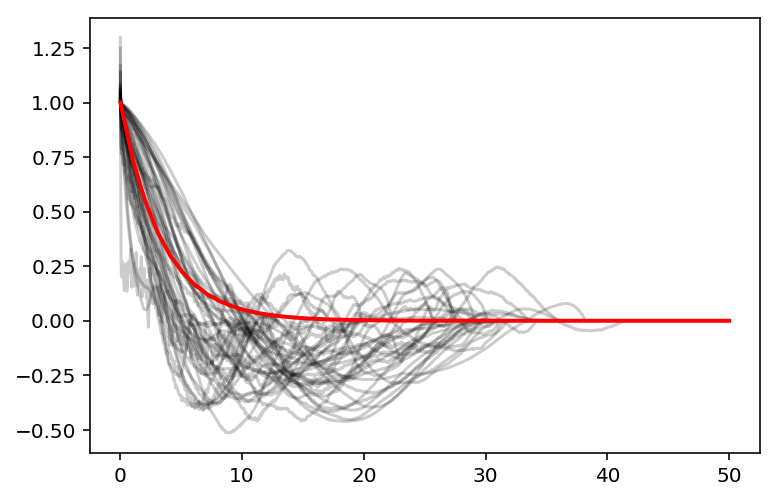

In [68]:
for i, lag, acf in zip(range(len(lags)), lags, acfs):
    plt.plot(lag, acf/np.percentile(acf, 99.9), color='k', alpha=0.2)

fit_limit = all_lags < 5

def model(p, lags):
    return np.exp(-lags * p[0])
    
def chi2(p, lags): 
    return np.sum((model(p, lags) - all_acfs[fit_limit])**2)

from scipy.optimize import fmin_powell

result = fmin_powell(chi2, [0.25], args=(all_lags[fit_limit],))

plt.plot(x, model([result], x), 'r', lw=2)

print("Exponential term: ", result)

In [149]:
result

array(0.29515529539822544)

In [167]:
from celerite import terms
import celerite

kernel = terms.JitterTerm(log_sigma=np.log(np.nanmedian(err)))
kernel.freeze_parameter('log_sigma')
kernel += terms.RealTerm(log_a=0, log_c=np.log(result)) 
kernel.freeze_parameter('terms[1]:log_c')

gp = celerite.GP(kernel, mean=1, fit_white_noise=True, fit_mean=True)
gp.compute(time)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

from scipy.optimize import minimize

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(flux, gp))
gp.set_parameter_vector(soln.x)
print(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

[-15.45759496   0.99756341]
Final log-likelihood: 489167.234978104


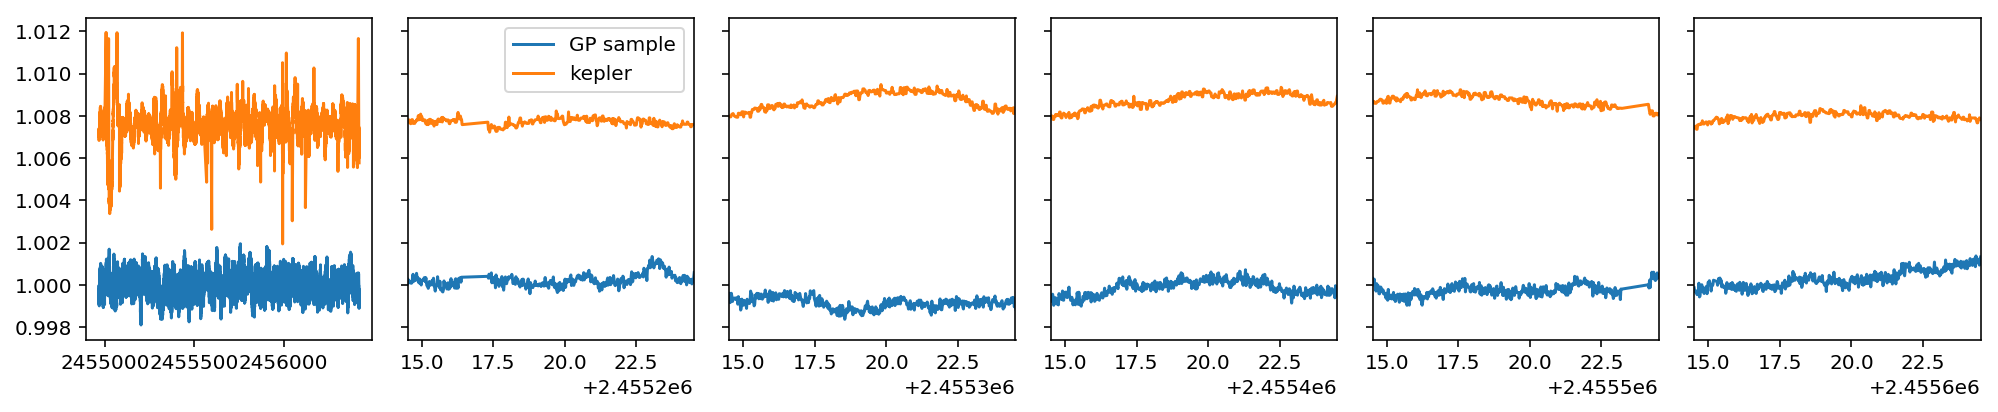

In [168]:
fake_lc = gp.sample()

fake_lc -= np.polyval(np.polyfit(time-time.mean(), fake_lc, 2), time-time.mean()) - 1 

fig, ax = plt.subplots(1, 6, figsize=(14, 3), sharey=True)
ax[0].plot(time, fake_lc, label='GP sample')
ax[0].plot(time, flux + 0.01, label='kepler')

ax[1].plot(time, fake_lc, label='GP sample')
ax[1].plot(time, flux + 0.01, label='kepler')
ax[1].set_xlim([time.min()+250, time.min()+260])

ax[2].plot(time, fake_lc, label='GP sample')
ax[2].plot(time, flux + 0.01, label='kepler')
ax[2].set_xlim([time.min()+350, time.min()+360])


ax[3].plot(time, fake_lc, label='GP sample')
ax[3].plot(time, flux + 0.01, label='kepler')
ax[3].set_xlim([time.min()+450, time.min()+460])

ax[4].plot(time, fake_lc, label='GP sample')
ax[4].plot(time, flux + 0.01, label='kepler')
ax[4].set_xlim([time.min()+550, time.min()+560])

ax[5].plot(time, fake_lc, label='GP sample')
ax[5].plot(time, flux + 0.01, label='kepler')
ax[5].set_xlim([time.min()+650, time.min()+660])

ax[1].legend()
fig.tight_layout()
fig.savefig('k62_gp_sample.png', dpi=200, bbox_inches='tight')

In [156]:
from interpacf import interpolated_acf

lag, acf = interpolated_acf(time, fake_lc - 1)

In [166]:
acf.max()

0.01550715749939101

(0, 10)

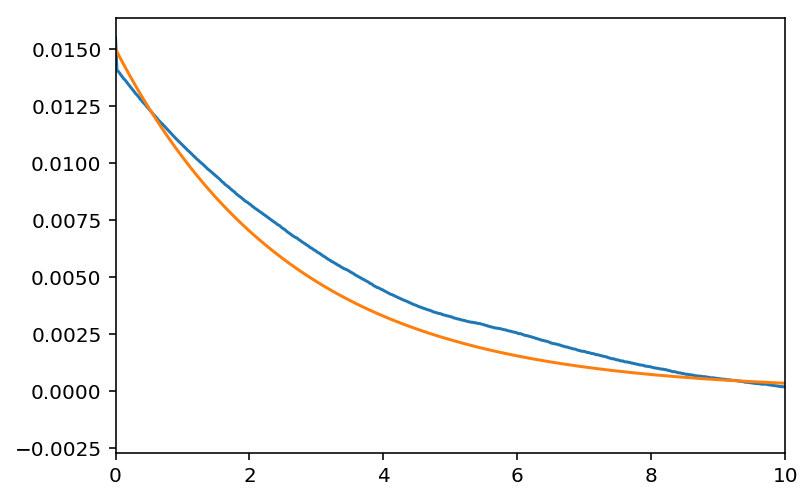

In [160]:
plt.plot(lag, acf)
plt.plot(lag, 0.015*np.exp(-0.38*lag))
plt.xlim([0, 10])

In [169]:
from astropy.modeling.blackbody import blackbody_lambda

In [201]:
wavelengths = np.linspace(0.1, 10, 10000) * u.um

kepler_wavelength, kepler_trans = np.loadtxt('../libra/data/filters/kepler_response_hires1.txt', unpack=True)
kepler_wavelength /= 1000
nirspec_wavelength, nirspec_trans = np.loadtxt('../libra/data/etc/NIRSpec_S1600_prism_clear_throughput.csv', unpack=True, delimiter=',')

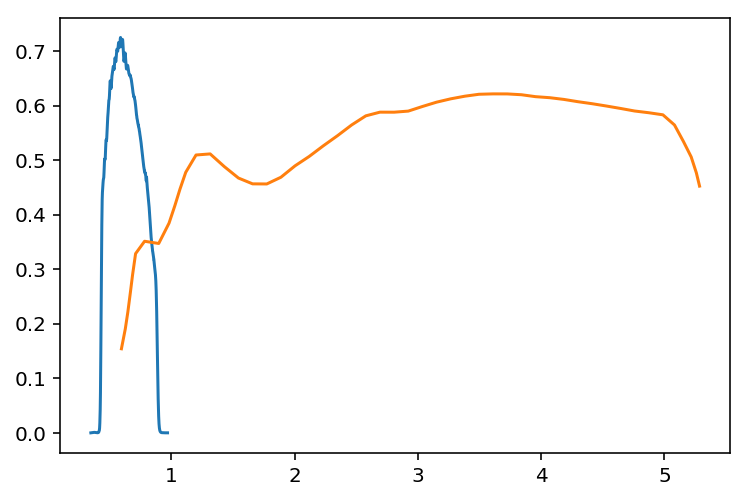

In [202]:
plt.plot(kepler_wavelength, kepler_trans)
plt.plot(nirspec_wavelength, nirspec_trans)

In [207]:
k62_teff = 4925

intensity_contrast = 0.12

def contrast_diff(p):
    return abs(np.trapz(blackbody_lambda(wavelengths, p[0]).value, wavelengths.value) / 
               np.trapz(blackbody_lambda(wavelengths, k62_teff).value, wavelengths.value) - intensity_contrast)

from scipy.optimize import fmin_powell

k62_cool = fmin_powell(contrast_diff, [4000])
print(k62_cool)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 177
2901.616735520316


In [204]:
cool_kepler = np.trapz(blackbody_lambda(wavelengths, k62_cool).value * 
                       np.interp(wavelengths.value, kepler_wavelength, kepler_trans) * wavelengths.value, 
                       wavelengths.value)

hot_kepler = np.trapz(blackbody_lambda(wavelengths, k62_teff).value * 
                      np.interp(wavelengths.value, kepler_wavelength, kepler_trans) * wavelengths.value, 
                      wavelengths.value)

cool_nirspec = np.trapz(blackbody_lambda(wavelengths, k62_cool).value * 
                        np.interp(wavelengths.value, nirspec_wavelength, nirspec_trans) * wavelengths.value, 
                        wavelengths.value)

hot_nirspec = np.trapz(blackbody_lambda(wavelengths, k62_teff).value * 
                       np.interp(wavelengths.value, nirspec_wavelength, nirspec_trans) * wavelengths.value, 
                       wavelengths.value)

In [209]:
ratio = cool_nirspec * hot_kepler / (cool_kepler * hot_nirspec)

print(ratio)

5.07761613988
